### Step 1: Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import *
import xgboost as xgb
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

### Step 2: Define working directories

In [2]:
path_raw_data = 'C:/Users/lbros/Documents/MIDS/W207/final_project/raw_data/'
path_clean_data = 'C:/Users/lbros/Documents/MIDS/W207/final_project/clean_data/'

### Step 3: Load clean data

#### Split ratings

In [3]:
# load ratings dataframes
dev_train = pd.read_csv(path_clean_data + 'dev_train.csv')
dev_test = pd.read_csv(path_clean_data + 'dev_test.csv')
test_train = pd.read_csv(path_clean_data + 'test_train.csv')
test_test = pd.read_csv(path_clean_data + 'test_test.csv')

In [4]:
# drop 'Unnamed 0' column
dev_train.drop('Unnamed: 0', axis=1, inplace=True)
dev_test.drop('Unnamed: 0', axis=1, inplace=True)
test_train.drop('Unnamed: 0', axis=1, inplace=True)
test_test.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
# print dataframes shapes
print('Shapes')
print('dev_train:', dev_train.shape)
print('dev_test:', dev_test.shape)
print('test_train:', test_train.shape)
print('test_test:', test_test.shape)

Shapes
dev_train: (906733, 3)
dev_test: (5000, 3)
test_train: (19545941, 3)
test_test: (110715, 3)


In [6]:
# print dataframes columns
print(dev_train.columns)
print(dev_test.columns)
print(test_train.columns)
print(test_test.columns)

Index(['userId', 'imdb_id', 'rating'], dtype='object')
Index(['userId', 'imdb_id', 'rating'], dtype='object')
Index(['userId', 'imdb_id', 'rating'], dtype='object')
Index(['userId', 'imdb_id', 'rating'], dtype='object')


#### Movies

In [7]:
# load movies dataframe
movies_df = pd.read_csv(path_clean_data + 'movies_final.csv')

In [8]:
# set imdb_id as index
movies_df.set_index('imdb_id', verify_integrity=True, inplace=True)

In [9]:
# Find the proportion of movies with an unknown tagline
# Since more than half of movies in the dataset don't have a tagline, we'll drop this field
print('Proportion of movies with unknown tagline: {:.4f}'.format(len(movies_df[movies_df.tagline == 'unknown'])/(len(movies_df))))

# Find the proportion of movies with unknown overview - only about 2% of movies are missing this field
print('Proportion of movies with unknown overview: {:.4f}'.format(len(movies_df[movies_df.overview == 'unknown'])/(len(movies_df))))

# Find the proportion of movies with unknown description - ~ one-third of movies don't have a result for this field
# Since the overview field also contains a description, but contains fewer missing values, we'll use this field
print('Proportion of movies with unknown description: {:.4f}'.format(len(movies_df[movies_df.description == 'unknown'])/(len(movies_df))))

# Find the proportion of movies without production companies or production countries listed
# Nearly a third of films in the dataset don't have a value for production companies or production countries
# We'll drop these fields
print('Proportion of movies with unknown production companies or countries: {:.4f}'.format(len(
    (movies_df[(movies_df.production_companies == 'unknown') | (movies_df.production_countries == 'unknown')]))
                                                     /len(movies_df)))

# Only a small proportion of films are missing cast or crew names, so we'll keep these fields
print('Proportion of movies with unknown cast or crew names: {:.4f}'.format(len(
    (movies_df[(movies_df.cast_names == 'unknown') | (movies_df.crew_names == 'unknown')]))
                                                     /len(movies_df)))

Proportion of movies with unknown tagline: 0.5505
Proportion of movies with unknown overview: 0.0213
Proportion of movies with unknown description: 0.3161
Proportion of movies with unknown production companies or countries: 0.2719
Proportion of movies with unknown cast or crew names: 0.0609


In [10]:
# remove fields unnamed: 0, id, tagline, description, production_countries, production_companies
movies_df = movies_df.drop(['Unnamed: 0', 'id', 'tagline', 
                            'description', 'production_countries', 'production_companies'], axis=1)

In [11]:
# print dataframe shape
movies_df.shape

(44628, 173)

In [12]:
# print dataframe columns
movies_df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'originally_english',
       'overview', 'popularity', 'revenue', 'runtime', 'title', 'video',
       ...
       'zh', 'zu', 'canceled', 'in-production', 'planned', 'post-production',
       'released', 'rumored', 'cast_names', 'crew_names'],
      dtype='object', length=173)

### Step 4: Vectorize text fields

Since we had insufficient memory to keep all text features from all fields, we chose to limit the features retained from transforming the text features in the literature to a subset of features. Based upon examples in the literature, we chose to keep the top 200 most significant words to the overview and title fields. We elected to further narrow the crew and cast names to the 100 most significant crew and cast names respectively.

In [13]:
# create an instance of a TfidfVectorizer object for overview
# set it to keep the top 200 most significant words in the overview column
tfidf_overview = TfidfVectorizer(max_features=200)
t_overview = tfidf_overview.fit_transform(movies_df.overview)

# create a dataframe of the transformed top 200 overview features
overview = pd.DataFrame(t_overview.todense()).add_prefix('overview_')

# fill the NA values in the title column with unknown
movies_df.title.fillna('unknown', inplace=True)

# create an instance of a TfidfVectorizer object for title
# set it to keep the top 200 most significant words in the title column
tfidf_title = TfidfVectorizer(max_features=200)
t_title = tfidf_title.fit_transform(movies_df.title)

# create a dataframe of the transformed top 200 overview features
title = pd.DataFrame(t_title.todense()).add_prefix('title_')

# create an instance of a TfidfVectorizer object for cast names, keeping the 100 most significant cast names
tfidf_cast = TfidfVectorizer(max_features=100)
t_cast = tfidf_cast.fit_transform(movies_df.cast_names)

# create a dataframe of the transformed top 100 cast name features
cast = pd.DataFrame(t_cast.todense()).add_prefix('cast_')

# create an instance of a TfidfVectorizer for crew names, keeping the 100 most significant crew names
tfidf_crew = TfidfVectorizer(max_features=100)
t_crew = tfidf_crew.fit_transform(movies_df.crew_names)

# create a dataframe of the transformed top 100 crew name features
crew = pd.DataFrame(t_crew.todense()).add_prefix('crew_')

# concatenate these columns into a single dataframe
text = pd.concat([overview, title, cast, crew], axis=1)

# free-up memory deleting intermediate objects
del overview
del title
del cast
del crew

# drop the text columns that have been converted to numeric scores from movies_df
movies_df.drop(['overview', 'title', 'cast_names', 'crew_names'], axis=1, inplace=True)

# add back to the movies_df the numeric representations of the original text columns
movies_df = pd.concat([movies_df.reset_index(), text], axis=1).set_index('imdb_id')
print('movies_df shape: ', movies_df.shape)

# free-up memory deleting intermediate objects
del text

movies_df shape:  (44628, 769)


### Step 5: Normalize features

In [67]:
# transform movies_df in a numpy array
a = movies_df.values

# create an instance of a MinMaxScaler and fit it to the numeric data
min_max_sc = MinMaxScaler()
num_rep = min_max_sc.fit_transform(a)
print('num_rep shape: ', num_rep.shape)

num_rep shape:  (44628, 769)


In [15]:
# the num_rep dataset has a high degree of sparsity; therefore, we'll use CSR to reduce model runtime (improve space complexity)
print('The sparsity of the movies numeric metadata is:',
      round((np.size(num_rep)-np.count_nonzero(num_rep))/np.size(num_rep)*100,2),
      'percent')

The sparsity of the movies numeric metadata is: 97.4 percent


In [16]:
# reduce the movies dataframe to a csr sparse matrix to reduce classifier run time
movie_features_csr = csr_matrix(num_rep)
print('movie_features_csr: ', movie_features_csr.shape)

# free-up memory deleting intermediate objects
del num_rep

movie_features_csr:  (44628, 769)


### Step 6: Reduce dimensionality using PCA and then via feature selection using XGBoost

#### Standardize the data, test the correlation, and reduce using PCA until 70 - 80% explained variance is achieved.

In [68]:
# Create an instance of a Standard Scaler and fit it to the numeric data
sc = StandardScaler()
features = sc.fit_transform(a)

# free-up memory deleting intermediate objects
del a

In [69]:
# Create the correlation matrix between all dataframe values to see if PCA reduction is applicable
cm = movies_df.corr().values

In [70]:
# There are only 92 features with a moderate degree of correlation (~11.96%)
# This indicates that PCA reduction might not be the best choice for reducing the number of features
mod_corr = np.count_nonzero((cm >= 0.3) & (cm < 1))
print(f'{mod_corr} of {cm.shape[1]} features ({"{:.2%}".format((mod_corr/cm.shape[1]))}) '
      f'have a moderate degree of correlation')

92 of 769 features (11.96%) have a moderate degree of correlation


In [71]:
# Use PCA to reduce the number of dimensions and check the explained variance sum
# According to the literature, a good rule of thumb for fraction of explained variance is 70 - 80%
print("Running PCA on Movie Features... \n")
ncomp = 475
pca = PCA(n_components=ncomp)
pca_features = pca.fit_transform(features)
print('pca_features shape: ', pca_features.shape)
pca_variance = pca.explained_variance_ratio_.sum()
print('pca_variance: {:.3f}'.format(pca_variance))

Running PCA on Movie Features... 

pca_features shape:  (44628, 475)
pca_variance:  0.6953204727945989


#### Find the most important features and filter the dataset via XGBoost

Since less than 12% of features have a correlation coefficient of >= 0.3 (excluding the correlations between each feature and itself) and a large number of features must be retained in order to explain 70% of the variance, we decided to try another approach to narrow down the number of features in our model. 

Because it is too computationally expensive to determine which features are most important in determining the rank that each user gives a movie, we chose to narrow the dataset based upon the most important features in determining how well a movie is liked on average. We theorize that most users will like or dislike a film for the same reasons as the general population of reviewers. Since many movies have few reviews, in order to determine which features are important, we will first calculate the Imdb weighted average value for each movie. The formula for the weighted average field was found at the following site: https://medium.com/@developeraritro/building-a-recommendation-system-using-weighted-hybrid-technique-75598b6be8ed

Since the Imdb weighted average feature will be continuous and on a different scale than ratings (0 - 5), we will use XGBRegressor to evaluate feature importance. The most important features will then be selected and the hit rate tests for the best performing classifiers re-run to see if reducing the features used improves hit rate performance.

In [75]:
# Create the colum for the weighted average
v = movies_df['vote_count']
R = movies_df['vote_average']
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(.7)
movies_df['weighted_avg'] = ((R*v) + (C*m))/(v+m)

In [76]:
# Create training and test data sets from the features
# The y variable will be the weighted average rating
X, Y = movies_df.loc[:, movies_df.columns != 'weighted_avg'], movies_df.weighted_avg

# Split the movies into training and test data
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.50, random_state=42)

In [77]:
# Create an instance of an XGBRegressor, with a seed for reproducibility
xgb = XGBRegressor(seed = 20)

# Define the parameters to be tested with GridSearch CV, using common parameter values
params = {'max_depth':[3,6,10], # Set the maximum depth of a tree
          'learning_rate':[0.01, 0.05, 0.1], # Set the learning rate
          'subsample': [0.6, 0.8, 1], # Set the fraction of data to be used in each fitting step
          'colsample_bytree': [0.3, 0.5, 0.7, 1], # Set the fraction of features to be used in each fitting step
          }
    
# Create an instance of a grid search cv object to test combinations of the parameters
clf = GridSearchCV(estimator=xgb, 
                   param_grid=params,
                   scoring='neg_mean_squared_error',
                   cv=3)

# Fit the Grid Search object to the training data from the movies dataset
clf.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# Return the model with the parameters with the best score on the training data (from GridSearch)
optimized_xgb = clf.best_estimator_

In [ ]:
# Store the feature importances in a variable
thresholds = optimized_xgb.feature_importances_

In [ ]:
# Get the smallest non-zero feature importance
min_threshold = min(i for i in thresholds if i > 0)

In [ ]:
# Find the number of features with an importance greater than or equal to the minimum threshold value
np.count_nonzero(optimized_xgb.feature_importances_ >= min_threshold)

In [ ]:
# Select features, filtering out only those features with an importance score of 0
selection = SelectFromModel(optimized_xgb, threshold=min_threshold, prefit=True)
xgb_select_features = selection.transform(X)

In [ ]:
# Create a dataframe from these features with non-zero importance to be used in our classifier test
xgb_features = pd.DataFrame(xgb_select_features)

# free-up memory deleting intermediate objects
del xgb_select_features

In [ ]:
# create an instance of a MinMaxScaler and fit it to the numeric data
min_max_sc = MinMaxScaler()
norm_xgb_features = min_max_sc.fit_transform(xgb_features.values)

# free-up memory deleting intermediate objects
del xgb_features

In [ ]:
# Convert to a CSR sparse matrix
xgb_features_csr = csr_matrix(norm_xgb_features)
print('xgb_features_csr shape: ', xgb_features_csr.shape)

# free-up memory deleting intermediate objects
del norm_xgb_features

### Step 7: Define functions to test and tune hyperparameters for different classifiers

In [17]:
def run_clf(user_id, clf, num_rep, train_ratings_data=dev_train, test_ratings_data=dev_test, movies_data=movies_df, num_reshuffles=0):
    
    '''Run a classifier for a single user and return the score'''
    
    # get movies and ratings from user training data
    train_movies = train_ratings_data[train_ratings_data['userId']==user_id]['imdb_id']
    train_ratings = train_ratings_data[train_ratings_data['userId']==user_id]['rating']
    #print('User {} rated {} movies in training set.'.format(user_id, len(train_movies)))
    #print('User {} gave {} positive ratings and {} negative ratings.'.format(user_id, (train_ratings==1).sum(), (train_ratings==0).sum()), '\n')
    
    # get movie and rating for hold out user test data
    hold_out_movie = test_ratings_data[test_ratings_data['userId']==user_id]['imdb_id']
    hold_out_rating = test_ratings_data[test_ratings_data['userId']==user_id]['rating']
    #print('User {} rated {} movie in the hold-out set.'.format(user_id, len(hold_out_movie)))
    #print('User {} gave a {} rating for the hold-out movie.'.format(user_id, int(hold_out_rating)), '\n')
    
    # complement test data with other 99 randomly selected movies
    allowed_list = movies_data.loc[~movies_data.index.isin(train_movies.append(hold_out_movie))]
    rd_movies = allowed_list.sample(n=99, replace=False).index.to_series()
    test_movies = hold_out_movie.append(rd_movies)
    
    # extract X_train and X_test matrices
    X_train = num_rep[[movies_data.index.get_loc(x) for x in train_movies], :]
    #print('X_train shape:', X_train.shape)
    X_test = num_rep[[movies_data.index.get_loc(x) for x in test_movies], :]
    #print('X_test shape:', X_test.shape)
    
    # extract y_train vector
    y_train = train_ratings.values
    #print('y_train shape:', y_train.shape, '\n')
    
    # fit training data
    clf.fit(X_train, y_train)
    # compute probabilities for each class
    proba = clf.predict_proba(X_test)
    
    # compute the ranking for class==test_ratings
    ranking = np.argsort(proba, axis=0)[:,clf.classes_[clf.classes_==int(hold_out_rating)]].reshape(100,1)
    
    # store the vote_count for each movie
    popularity = movies_data.loc[movies_data.index.isin(test_movies)]['vote_count'].values.reshape(100,1)
    
    # for each reshuffle
    for _ in np.arange(num_reshuffles):
        # compute the most popular movie among the top-10 and least popular among the others
        most_popular = ranking[(popularity == popularity[ranking > 89].max()) & (ranking > 89)][0]
        least_popular = ranking[(popularity == popularity[ranking < 90].min()) & (ranking < 90)][0]
        # reshuffle the ranks of the most popular among the top-10 with the least popular among the others
        ranking[ranking == most_popular] = 1000
        ranking[ranking == least_popular] = -1000
        ranking[ranking == 1000] = least_popular
        ranking[ranking == -1000] = most_popular
    
    # apply a positive hit if test example ranked on top-10 in descending order
    hit = ranking[0] > 89
    
    # compute tuple (true_label, predicted_label) for hold out test movie
    true_label = int(hold_out_rating)
    pred_label = clf.predict(X_test)[0]
    tup = (pred_label, true_label)
    
    # compute the novelty score (average number of votes for the top-10 movies)
    novelty = popularity[ranking > 89].mean()
    
    return hit, tup, novelty

In [18]:
def get_hit_rate(user_list, clf, num_rep, train_ratings_data=dev_train, test_ratings_data=dev_test, movies_data=movies_df, num_reshuffles=0):

    '''Compute hit rate, f1 score and novelty score across diferent users'''
    
    hit_list = []
    conf_matrix = {(0,0): 0, (0,1): 0, (1,0): 0, (1,1): 0}
    novelty_list = []
    for user_id in user_list:
        hit, tup, novelty = run_clf(user_id, clf=clf, num_rep=num_rep, train_ratings_data=train_ratings_data, test_ratings_data=test_ratings_data, 
                            movies_data=movies_data, num_reshuffles=num_reshuffles)
        hit_list.append(bool(hit))
        conf_matrix[tup] += 1
        novelty_list.append(novelty)
    hit_rate = sum(hit_list) / len(hit_list)
    precision = conf_matrix[(1,1)] / (conf_matrix[(1,1)] + conf_matrix[(1,0)])
    recall = conf_matrix[(1,1)] / (conf_matrix[(1,1)] + conf_matrix[(0,1)])
    f1_score = 0 if (precision + recall == 0) else 2 * (precision * recall) / (precision + recall)
    novelty_score = sum(novelty_list) / len(novelty_list)
    return hit_rate, f1_score, novelty_score

In [19]:
def run_gmm(user_id, n_components, num_rep, train_ratings_data=dev_train, test_ratings_data=dev_test, movies_data=movies_df, num_reshuffles=0):
    
    '''Fit two GMMs, one for the positive and other for the negative examples, and use
    the weighted log probabilities to compute the ranking and return the score'''
    
    # get movies and ratings from user training data
    train_movies = train_ratings_data[train_ratings_data['userId']==user_id]['imdb_id']
    train_ratings = train_ratings_data[train_ratings_data['userId']==user_id]['rating']
    #print('User {} rated {} movies in training set.'.format(user_id, len(train_movies)))
    #print('User {} gave {} positive ratings and {} negative ratings.'.format(user_id, (train_ratings==1).sum(), (train_ratings==0).sum()), '\n')
    
    # get movie and rating for hold out user test data
    hold_out_movie = test_ratings_data[test_ratings_data['userId']==user_id]['imdb_id']
    hold_out_rating = test_ratings_data[test_ratings_data['userId']==user_id]['rating']
    #print('User {} rated {} movie in the hold-out set.'.format(user_id, len(hold_out_movie)))
    #print('User {} gave a {} rating for the hold-out movie.'.format(user_id, int(hold_out_rating)), '\n')
    
    # complement test data with other 99 randomly selected movies
    allowed_list = movies_data.loc[~movies_data.index.isin(train_movies.append(hold_out_movie))]
    rd_movies = allowed_list.sample(n=99, replace=False).index.to_series()
    test_movies = hold_out_movie.append(rd_movies)
    
    # extract X_train and X_test matrices
    X_train = num_rep[[movies_data.index.get_loc(x) for x in train_movies], :].toarray()
    #print('X_train shape:', X_train.shape)
    X_test = num_rep[[movies_data.index.get_loc(x) for x in test_movies], :].toarray()
    #print('X_test shape:', X_test.shape)
    
    # extrac y_train vector
    y_train = train_ratings.values
    #print('y_train shape:', y_train.shape, '\n')
    
    # fit two GMMs, one for the positive labels and one for the negative labels
    gmm_0 = GaussianMixture(n_components=n_components, covariance_type='tied', random_state=100)
    gmm_0.fit(X_train[y_train==0])
    gmm_1 = GaussianMixture(n_components=n_components, covariance_type='tied', random_state=100)
    gmm_1.fit(X_train[y_train==1])
    
    # compute the weighted log probabilities for each test example in both models
    log_prob_0 = gmm_0.score_samples(X_test)
    log_prob_1 = gmm_1.score_samples(X_test)
    proba = np.vstack((log_prob_0, log_prob_1)).T
    
    # compute the ranking for class==test_ratings
    ranking = np.argsort(proba, axis=0)[:,int(hold_out_rating)]
    
    # store the vote_count for each movie
    popularity = movies_data.loc[movies_data.index.isin(test_movies)]['vote_count'].values.reshape(100,1)
    
    # for each reshuffle
    for _ in np.arange(num_reshuffles):
        # compute the most popular movie among the top-10 and least popular among the others
        most_popular = ranking[(popularity == popularity[ranking > 89].max()) & (ranking > 89)][0]
        least_popular = ranking[(popularity == popularity[ranking < 90].min()) & (ranking < 90)][0]
        # reshuffle the ranks of the most popular among the top-10 with the least popular among the others
        ranking[ranking == most_popular] = 1000
        ranking[ranking == least_popular] = -1000
        ranking[ranking == 1000] = least_popular
        ranking[ranking == -1000] = most_popular    
    
    # apply a positive hit if test example ranked on top-10 in descending order
    hit = ranking[0] > 89
    
    # compute tuple (true_label, predicted_label) for hold out test movie
    true_label = int(hold_out_rating)
    pred_label = 1 if proba[0,1] > proba[0,0] else 0 
    tup = (pred_label, true_label)
    
    # compute the novelty score (average number of votes for the top-10 movies)
    novelty = popularity[ranking > 89].mean()
    
    return hit, tup, novelty

In [20]:
def get_hit_rate_gmm(user_list, n_components, num_rep, train_ratings_data=dev_train, 
                     test_ratings_data=dev_test, movies_data=movies_df, num_reshuffles=0):

    '''Compute hit rate, f1 score and novelty score across diferent users for GMM'''
    
    hit_list = []
    conf_matrix = {(0,0): 0, (0,1): 0, (1,0): 0, (1,1): 0}
    novelty_list = []
    for user_id in user_list:
        hit, tup, novelty = run_gmm(user_id, n_components=n_components, num_rep=num_rep, train_ratings_data=train_ratings_data,
                           test_ratings_data=test_ratings_data, movies_data=movies_data, num_reshuffles=num_reshuffles)
        hit_list.append(bool(hit))
        conf_matrix[tup] += 1
        novelty_list.append(novelty)
    hit_rate = sum(hit_list) / len(hit_list)
    precision = conf_matrix[(1,1)] / (conf_matrix[(1,1)] + conf_matrix[(1,0)])
    recall = conf_matrix[(1,1)] / (conf_matrix[(1,1)] + conf_matrix[(0,1)])
    f1_score = 0 if (precision + recall == 0) else 2 * (precision * recall) / (precision + recall)
    novelty_score = sum(novelty_list) / len(novelty_list)
    return hit_rate, f1_score, novelty_score

In [21]:
def run_cosim(user_id, num_rep, train_ratings_data=dev_train, test_ratings_data=dev_test, movies_data=movies_df, num_reshuffles=0):
    
    '''Compute two cosine similarity distances for each example in the test set, one against the positive examples in the training
    set and other against the negative examples, and use the distances to compute the ranking and return the score'''
    
    # get movies and ratings from user training data
    train_movies = train_ratings_data[train_ratings_data['userId']==user_id]['imdb_id']
    train_ratings = train_ratings_data[train_ratings_data['userId']==user_id]['rating']
    #print('User {} rated {} movies in training set.'.format(user_id, len(train_movies)))
    #print('User {} gave {} positive ratings and {} negative ratings.'.format(user_id, (train_ratings==1).sum(), (train_ratings==0).sum()), '\n')
    
    # get movie and rating for hold out user test data
    hold_out_movie = test_ratings_data[test_ratings_data['userId']==user_id]['imdb_id']
    hold_out_rating = test_ratings_data[test_ratings_data['userId']==user_id]['rating']
    #print('User {} rated {} movie in the hold-out set.'.format(user_id, len(hold_out_movie)))
    #print('User {} gave a {} rating for the hold-out movie.'.format(user_id, int(hold_out_rating)), '\n')
    
    # complement test data with other 99 randomly selected movies
    allowed_list = movies_data.loc[~movies_data.index.isin(train_movies.append(hold_out_movie))]
    rd_movies = allowed_list.sample(n=99, replace=False).index.to_series()
    test_movies = hold_out_movie.append(rd_movies)
    
    # extract X_train and X_test matrices
    X_train = num_rep[[movies_data.index.get_loc(x) for x in train_movies], :]
    #print('X_train shape:', X_train.shape)
    X_test = num_rep[[movies_data.index.get_loc(x) for x in test_movies], :]
    #print('X_test shape:', X_test.shape)
    
    # extrac y_train vector
    y_train = train_ratings.values
    #print('y_train shape:', y_train.shape, '\n')
    
    # compute the cosine similarities, one for the positive labels and one for the negative labels
    cosim_0 = cosine_similarity(X_test, X_train[y_train==0]).sum(axis=1)
    cosim_1 = cosine_similarity(X_test, X_train[y_train==1]).sum(axis=1)
    distance = np.vstack((cosim_0, cosim_1)).T

    # compute the ranking for class==test_ratings
    ranking = np.argsort(distance, axis=0)[:,int(hold_out_rating)]
    
    # store the vote_count for each movie
    popularity = movies_data.loc[movies_data.index.isin(test_movies)]['vote_count'].values.reshape(100,1)
    
    # for each reshuffle
    for _ in np.arange(num_reshuffles):
        # compute the most popular movie among the top-10 and least popular among the others
        most_popular = ranking[(popularity == popularity[ranking < 10].max()) & (ranking < 10)][0]
        least_popular = ranking[(popularity == popularity[ranking > 9].min()) & (ranking > 9)][0]
        # reshuffle the ranks of the most popular among the top-10 with the least popular among the others
        ranking[ranking == most_popular] = 1000
        ranking[ranking == least_popular] = -1000
        ranking[ranking == 1000] = least_popular
        ranking[ranking == -1000] = most_popular
    
    # apply a positive hit if test example ranked on top-10 in ascending order
    hit = ranking[0] < 10
    
    # compute tuple (true_label, predicted_label) for hold out test movie
    true_label = int(hold_out_rating)
    pred_label = 1 if distance[0,1] < distance[0,0] else 0 
    tup = (pred_label, true_label)
    
    # compute the novelty score (average number of votes for the top-10 movies)
    novelty = popularity[ranking < 10].mean()
    
    return hit, tup, novelty

In [22]:
def get_hit_rate_cosim(user_list, num_rep, train_ratings_data=dev_train, 
                       test_ratings_data=dev_test, movies_data=movies_df, num_reshuffles=0):

    '''Compute hit rate, f1 score and novelty score across diferent users for cosine similarity'''
    
    hit_list = []
    conf_matrix = {(0,0): 0, (0,1): 0, (1,0): 0, (1,1): 0}
    novelty_list = []
    for user_id in user_list:
        hit, tup, novelty = run_cosim(user_id, num_rep=num_rep, train_ratings_data=train_ratings_data,
                        test_ratings_data=test_ratings_data, movies_data=movies_data, num_reshuffles=num_reshuffles)
        hit_list.append(bool(hit))
        conf_matrix[tup] += 1
        novelty_list.append(novelty)
    hit_rate = sum(hit_list) / len(hit_list)
    precision = conf_matrix[(1,1)] / (conf_matrix[(1,1)] + conf_matrix[(1,0)])
    recall = conf_matrix[(1,1)] / (conf_matrix[(1,1)] + conf_matrix[(0,1)])
    f1_score = 0 if (precision + recall == 0) else 2 * (precision * recall) / (precision + recall)
    novelty_score = sum(novelty_list) / len(novelty_list)
    return hit_rate, f1_score, novelty_score

In [23]:
def run_baseline(user_id, num_rep, train_ratings_data=dev_train, test_ratings_data=dev_test, movies_data=movies_df, num_reshuffles=0):
    
    '''Run a random classifier as a baseline'''
    
    # get movies and ratings from user training data
    train_movies = train_ratings_data[train_ratings_data['userId']==user_id]['imdb_id']
    train_ratings = train_ratings_data[train_ratings_data['userId']==user_id]['rating']
    #print('User {} rated {} movies in training set.'.format(user_id, len(train_movies)))
    #print('User {} gave {} positive ratings and {} negative ratings.'.format(user_id, (train_ratings==1).sum(), (train_ratings==0).sum()), '\n')
    
    # get movie and rating for hold out user test data
    hold_out_movie = test_ratings_data[test_ratings_data['userId']==user_id]['imdb_id']
    hold_out_rating = test_ratings_data[test_ratings_data['userId']==user_id]['rating']
    #print('User {} rated {} movie in the hold-out set.'.format(user_id, len(hold_out_movie)))
    #print('User {} gave a {} rating for the hold-out movie.'.format(user_id, int(hold_out_rating)), '\n')
    
    # complement test data with other 99 randomly selected movies
    allowed_list = movies_data.loc[~movies_data.index.isin(train_movies.append(hold_out_movie))]
    rd_movies = allowed_list.sample(n=99, replace=False).index.to_series()
    test_movies = hold_out_movie.append(rd_movies)
    
    # extract X_train and X_test matrices
    X_train = num_rep[[movies_data.index.get_loc(x) for x in train_movies], :]
    #print('X_train shape:', X_train.shape)
    X_test = num_rep[[movies_data.index.get_loc(x) for x in test_movies], :]
    #print('X_test shape:', X_test.shape)
    
    # extrac y_train vector
    y_train = train_ratings.values
    #print('y_train shape:', y_train.shape, '\n')
    
    # assign random probabilities for each class
    proba = np.random.uniform(low=0.0, high=1.0, size=200).reshape(100,2)
    # compute the ranking for class==test_ratings
    ranking = np.argsort(proba, axis=0)[:,int(hold_out_rating)]
    
    # store the vote_count for each movie
    popularity = movies_data.loc[movies_data.index.isin(test_movies)]['vote_count'].values.reshape(100,1)
    
    # for each reshuffle
    for _ in np.arange(num_reshuffles):
        # compute the most popular movie among the top-10 and least popular among the others
        most_popular = ranking[(popularity == popularity[ranking > 89].max()) & (ranking > 89)][0]
        least_popular = ranking[(popularity == popularity[ranking < 90].min()) & (ranking < 90)][0]
        # reshuffle the ranks of the most popular among the top-10 with the least popular among the others
        ranking[ranking == most_popular] = 1000
        ranking[ranking == least_popular] = -1000
        ranking[ranking == 1000] = least_popular
        ranking[ranking == -1000] = most_popular  
    
    # apply a positive hit if test example ranked on top-10 in descending order
    hit = ranking[0] > 89
    
    # compute tuple (true_label, predicted_label) for hold out test movie
    true_label = int(hold_out_rating)
    pred_label = 1 if proba[0,1] > proba[0,0] else 0 
    tup = (pred_label, true_label)
    
    # compute the novelty score (average number of votes for the top-10 movies)
    novelty = popularity[ranking > 89].mean()
    
    return hit, tup, novelty

In [24]:
def get_hit_rate_baseline(user_list, num_rep, train_ratings_data=dev_train, test_ratings_data=dev_test, movies_data=movies_df, num_reshuffles=0):

    '''Compute hit rate, f1 score and novelty score across diferent users for random baseline'''
    
    hit_list = []
    conf_matrix = {(0,0): 0, (0,1): 0, (1,0): 0, (1,1): 0}
    novelty_list = []
    for user_id in user_list:
        hit, tup, novelty = run_baseline(user_id, num_rep=num_rep, train_ratings_data=train_ratings_data,
                                test_ratings_data=test_ratings_data, movies_data=movies_data, num_reshuffles=num_reshuffles)
        hit_list.append(bool(hit))
        conf_matrix[tup] += 1
        novelty_list.append(novelty)
    hit_rate = sum(hit_list) / len(hit_list)
    precision = conf_matrix[(1,1)] / (conf_matrix[(1,1)] + conf_matrix[(1,0)])
    recall = conf_matrix[(1,1)] / (conf_matrix[(1,1)] + conf_matrix[(0,1)])
    f1_score = 0 if (precision + recall == 0) else 2 * (precision * recall) / (precision + recall)
    novelty_score = sum(novelty_list) / len(novelty_list)
    return hit_rate, f1_score, novelty_score

In [37]:
def run_ensemble(user_id, num_rep, train_ratings_data=dev_train, test_ratings_data=dev_test, movies_data=movies_df, num_reshuffles=0):
    
    '''Run all classifiers for a single user and compute the average probability before returning the score'''
    
    # get movies and ratings from user training data
    train_movies = train_ratings_data[train_ratings_data['userId']==user_id]['imdb_id']
    train_ratings = train_ratings_data[train_ratings_data['userId']==user_id]['rating']
    #print('User {} rated {} movies in training set.'.format(user_id, len(train_movies)))
    #print('User {} gave {} positive ratings and {} negative ratings.'.format(user_id, (train_ratings==1).sum(), (train_ratings==0).sum()), '\n')
    
    # get movie and rating for hold out user test data
    hold_out_movie = test_ratings_data[test_ratings_data['userId']==user_id]['imdb_id']
    hold_out_rating = test_ratings_data[test_ratings_data['userId']==user_id]['rating']
    #print('User {} rated {} movie in the hold-out set.'.format(user_id, len(hold_out_movie)))
    #print('User {} gave a {} rating for the hold-out movie.'.format(user_id, int(hold_out_rating)), '\n')
    
    # complement test data with other 99 randomly selected movies
    allowed_list = movies_data.loc[~movies_data.index.isin(train_movies.append(hold_out_movie))]
    rd_movies = allowed_list.sample(n=99, replace=False).index.to_series()
    test_movies = hold_out_movie.append(rd_movies)
    
    # extract X_train and X_test matrices
    X_train = num_rep[[movies_data.index.get_loc(x) for x in train_movies], :]
    #print('X_train shape:', X_train.shape)
    X_test = num_rep[[movies_data.index.get_loc(x) for x in test_movies], :]
    #print('X_test shape:', X_test.shape)
    
    # extrac y_train vector
    y_train = train_ratings.values
    #print('y_train shape:', y_train.shape, '\n')
    
    # initialize the models
    bnb = BernoulliNB(alpha=1.0)
    rfc = RandomForestClassifier(n_estimators=100, criterion='entropy')
    svm = SVC(C=1.0, kernel='rbf', probability=True)
    knn = KNeighborsClassifier(n_neighbors=15)
    lr = LogisticRegression(C=0.1)
    gmm_0 = GaussianMixture(n_components=3, covariance_type='tied', random_state=100)
    gmm_1 = GaussianMixture(n_components=3, covariance_type='tied', random_state=100)
    
    # fit training data
    bnb.fit(X_train, y_train)
    rfc.fit(X_train, y_train)
    svm.fit(X_train, y_train)
    knn.fit(X_train, y_train)
    lr.fit(X_train, y_train)
    gmm_0.fit(X_train[y_train==0].toarray())
    gmm_1.fit(X_train[y_train==1].toarray())
    
    # compute probabilities for each model for class==test_ratings
    bnb_proba = bnb.predict_proba(X_test)[:,int(hold_out_rating)].reshape(100,1)
    rfc_proba = rfc.predict_proba(X_test)[:,int(hold_out_rating)].reshape(100,1)
    svm_proba = svm.predict_proba(X_test)[:,int(hold_out_rating)].reshape(100,1)
    knn_proba = knn.predict_proba(X_test)[:,int(hold_out_rating)].reshape(100,1)
    lr_proba = lr.predict_proba(X_test)[:,int(hold_out_rating)].reshape(100,1)
    gmm_prob_0 = np.exp(gmm_0.score_samples(X_test.toarray()))
    gmm_prob_1 = np.exp(gmm_1.score_samples(X_test.toarray()))
    gmm_proba = np.vstack((gmm_prob_0, gmm_prob_1)).T[:,int(hold_out_rating)].reshape(100,1)
    
    # compute the average probabilities
    proba = np.hstack((bnb_proba, rfc_proba, svm_proba, knn_proba, lr_proba, gmm_proba)).mean(axis=1)
    
    # compute the ranking
    ranking = np.argsort(proba, axis=0)
    
    # store the vote_count for each movie
    popularity = movies_data.loc[movies_data.index.isin(test_movies)]['vote_count'].values.reshape(100,1)
    
    # for each reshuffle
    for _ in np.arange(num_reshuffles):
        # compute the most popular movie among the top-10 and least popular among the others
        most_popular = ranking[(popularity == popularity[ranking > 89].max()) & (ranking > 89)][0]
        least_popular = ranking[(popularity == popularity[ranking < 90].min()) & (ranking < 90)][0]
        # reshuffle the ranks of the most popular among the top-10 with the least popular among the others
        ranking[ranking == most_popular] = 1000
        ranking[ranking == least_popular] = -1000
        ranking[ranking == 1000] = least_popular
        ranking[ranking == -1000] = most_popular
    
    # apply a positive hit if test example ranked on top-10 in descending order
    hit = ranking[0] > 89
    
    # compute predictions for hold out test movie from each model
    bnb_pred = bnb.predict(X_test)[0]
    rfc_pred = rfc.predict(X_test)[0]
    svm_pred = svm.predict(X_test)[0]
    knn_pred = knn.predict(X_test)[0]
    lr_pred = lr.predict(X_test)[0]
    gmm_pred = 1 if gmm_prob_1[0] > gmm_prob_0[0] else 0
    sum_pred = bnb_pred + rfc_pred + svm_pred + knn_pred + lr_pred + gmm_pred
    
    # compute tuple (true_label, predicted_label) for hold out test movie
    true_label = int(hold_out_rating)
    pred_label = 1 if sum_pred >= 3 else 0 
    tup = (pred_label, true_label)
    
    # compute the novelty score (average number of votes for the top-10 movies)
    novelty = popularity[ranking > 89].mean()
    
    return hit, tup, novelty

In [38]:
def get_hit_rate_ensemble(user_list, num_rep, train_ratings_data=dev_train, test_ratings_data=dev_test, movies_data=movies_df, num_reshuffles=0):

    '''Compute hit rate, f1 score and novelty score across diferent users for ensemble method'''
    
    hit_list = []
    conf_matrix = {(0,0): 0, (0,1): 0, (1,0): 0, (1,1): 0}
    novelty_list = []
    for user_id in user_list:
        hit, tup, novelty = run_ensemble(user_id, num_rep=num_rep, train_ratings_data=train_ratings_data,
                                test_ratings_data=test_ratings_data, movies_data=movies_data, num_reshuffles=num_reshuffles)
        hit_list.append(bool(hit))
        conf_matrix[tup] += 1
        novelty_list.append(novelty)
    hit_rate = sum(hit_list) / len(hit_list)
    precision = conf_matrix[(1,1)] / (conf_matrix[(1,1)] + conf_matrix[(1,0)])
    recall = conf_matrix[(1,1)] / (conf_matrix[(1,1)] + conf_matrix[(0,1)])
    f1_score = 0 if (precision + recall == 0) else 2 * (precision * recall) / (precision + recall)
    novelty_score = sum(novelty_list) / len(novelty_list)
    return hit_rate, f1_score, novelty_score

### Step 8: Test different classifiers using the unreduced movies features converted to a CSR sparse matrix

In this section, we test the hit rates and f1 scores obtained via various classifiers that we've learned this semester, and compare the rates to that obtained by a random classifier. In each classifier test, all movie features are used. 

In [27]:
sample_size = 1000
clf_list = ['Base', 'Cosine Sim', 'BNB', 'RF', 'SVM', 'KNN', 'LR', 'GMM', 'Ensemble']
clf_hit_rate_scores = []
clf_f1_scores = []

In [28]:
# Set a random user list of [sample_size] users from the dev set to be tested via all classifiers
np.random.seed(100)
user_list = np.random.choice(dev_train['userId'].unique(), size=sample_size, replace=False)

#### Baseline (random classifier)

In [29]:
# compute the hit rate and f1 score
hit_rate, f1_score, novelty_score = get_hit_rate_baseline(user_list, num_rep=movie_features_csr)
# print results
print('Baseline (random classifier)')
print('hit rate=={:.3f} f1 score=={:.3f}'.format(hit_rate, f1_score))
# append best_score to clf_scores
clf_hit_rate_scores.append(hit_rate)
clf_f1_scores.append(f1_score)

Baseline (random classifier)
hit rate==0.091 f1 score==0.511


#### Cosine similarity

In [30]:
# compute the hit rate and f1 score
hit_rate, f1_score, novelty_score = get_hit_rate_cosim(user_list, num_rep=movie_features_csr)
# print results
print('Cosine similarity')
print('hit rate=={:.3f} f1 score=={:.3f}'.format(hit_rate, f1_score))
# append best_score to clf_scores
clf_hit_rate_scores.append(hit_rate)
clf_f1_scores.append(f1_score)

Cosine similarity
hit rate==0.089 f1 score==0.362


#### BernoulliNB

In [31]:
# define range for alpha parameter
param_range = [0.001, 0.01, 0.1, 1, 10]
# for different values of parameter alpha
hit_rate_list = []
f1_score_list = []
print('BernoulliNB')
for param in param_range:
    # initialize classifier
    bnb = BernoulliNB(alpha=param)
    # compute the hit rate and f1 score
    hit_rate, f1_score, novelty_score = get_hit_rate(user_list, num_rep=movie_features_csr, clf=bnb)
    # append hit rate to the hit_rate_list
    hit_rate_list.append(hit_rate)
    # append f1 score to the f1_score_list
    f1_score_list.append(f1_score)
    # print results
    print('For alpha=={:.3f} hit rate=={:.3f} f1 score=={:.3f}'.format(param, hit_rate, f1_score))
best_bnb_param = param_range[f1_score_list.index(max(f1_score_list))]
print('-'*50)
print('Best param: {:.3f}'.format(best_bnb_param))
print('Best f1 score: {:.3f}'.format(max(f1_score_list)))
# append best_score to clf_scores
clf_hit_rate_scores.append(max(hit_rate_list))
clf_f1_scores.append(max(f1_score_list))

BernoulliNB
For alpha==0.00001 hit rate==0.103 f1 score==0.639
For alpha==0.00010 hit rate==0.109 f1 score==0.639
For alpha==0.00100 hit rate==0.109 f1 score==0.637
For alpha==0.01000 hit rate==0.103 f1 score==0.634
For alpha==0.10000 hit rate==0.092 f1 score==0.640
For alpha==1.00000 hit rate==0.113 f1 score==0.661
--------------------------------------------------
Best param: 1.00000
Best f1 score: 0.661


#### Random Forest

In [32]:
# define range for n_estimators parameter
param_range = [5, 10, 50, 100, 500]
# for different values of n_estimators parameter
hit_rate_list = []
f1_score_list = []
print('Random Forest')
for param in param_range:
    # initialize classifier
    rfc = RandomForestClassifier(n_estimators=param, criterion='entropy')
    # compute the hit rate
    hit_rate, f1_score, novelty_score = get_hit_rate(user_list, num_rep=movie_features_csr, clf=rfc)
    # append hit rate to the hit_rate_list
    hit_rate_list.append(hit_rate)
    # append f1 score to the f1_score_list
    f1_score_list.append(f1_score)
    # print results
    print('For n_estimators=={:3} hit rate=={:.3f} f1 score=={:.3f}'.format(param, hit_rate, f1_score))
best_rf_param = param_range[f1_score_list.index(max(f1_score_list))]
print('-'*50)
print('Best param: {:3}'.format(best_rf_param))
print('Best f1 score: {:.3f}'.format(max(f1_score_list)))
# append best_score to clf_scores
clf_hit_rate_scores.append(max(hit_rate_list))
clf_f1_scores.append(max(f1_score_list))

Random Forest
For n_estimators==  1 hit rate==0.105 f1 score==0.620
For n_estimators==  2 hit rate==0.129 f1 score==0.501
For n_estimators==  5 hit rate==0.129 f1 score==0.653
For n_estimators== 10 hit rate==0.121 f1 score==0.658
For n_estimators== 50 hit rate==0.111 f1 score==0.680
For n_estimators==100 hit rate==0.101 f1 score==0.684
--------------------------------------------------
Best param: 100
Best f1 score: 0.684


#### SVM

In [33]:
# define range for C parameter
param_range = [0.001, 0.01, 0.1, 1, 10]
# for different values of C parameter
hit_rate_list = []
f1_score_list = []
print('SVM')
for param in param_range:
    # initialize classifier
    svm = SVC(C=param, kernel='rbf', probability=True)
    # compute the hit rate
    hit_rate, f1_score, novelty_score = get_hit_rate(user_list, num_rep=movie_features_csr, clf=svm)
    # append hit rate to the hit_rate_list
    hit_rate_list.append(hit_rate)
    # append f1 score to the f1_score_list
    f1_score_list.append(f1_score)
    # print results
    print('For C=={:.3f} hit rate=={:.3f} f1 score=={:.3f}'.format(param, hit_rate, f1_score))
best_svm_param = param_range[f1_score_list.index(max(f1_score_list))]
print('-'*50)
print('Best param: {:.3f}'.format(best_svm_param))
print('Best f1 score: {:.3f}'.format(max(f1_score_list)))
# append best_score to clf_scores
clf_hit_rate_scores.append(max(hit_rate_list))
clf_f1_scores.append(max(f1_score_list))

SVM
For C==0.001 hit rate==0.097 f1 score==0.656
For C==0.010 hit rate==0.097 f1 score==0.656
For C==0.100 hit rate==0.109 f1 score==0.656
For C==1.000 hit rate==0.088 f1 score==0.684
For C==10.000 hit rate==0.100 f1 score==0.668
--------------------------------------------------
Best param: 1.000
Best f1 score: 0.684


#### K-Nearest Neighbors

In [34]:
# define range for k (n_neighbors) parameter
param_range = [5, 10, 15, 20, 25]
# for different values of parameter k (n_beighbors)
hit_rate_list = []
f1_score_list = []
print('K-Nearest Neighbors')
for param in param_range:
    # initialize classifier
    knn = KNeighborsClassifier(n_neighbors=param)
    # compute the hit rate
    hit_rate, f1_score, novelty_score = get_hit_rate(user_list, num_rep=movie_features_csr, clf=knn)
    # append hit rate to the hit_rate_list
    hit_rate_list.append(hit_rate)
    # append f1 score to the f1_score_list
    f1_score_list.append(f1_score)
    # print results
    print('For k=={:2} hit rate=={:.3f} f1 score=={:.3f}'.format(param, hit_rate, f1_score))
best_knn_param = param_range[f1_score_list.index(max(f1_score_list))]
print('-'*50)
print('Best param: {:2}'.format(best_knn_param))
print('Best hit rate: {:.3f}'.format(max(f1_score_list)))
# append best_score to clf_scores
clf_hit_rate_scores.append(max(hit_rate_list))
clf_f1_scores.append(max(f1_score_list))

K-Nearest Neighbors
For k== 5 hit rate==0.152 f1 score==0.651
For k==10 hit rate==0.104 f1 score==0.627
For k==15 hit rate==0.104 f1 score==0.667
For k==20 hit rate==0.106 f1 score==0.642
For k==25 hit rate==0.134 f1 score==0.663
--------------------------------------------------
Best param: 15
Best hit rate: 0.667


#### Logistic Regression

In [35]:
# define range for C parameter
param_range = [0.0001, 0.001, 0.01, 0.1, 1]
# for different values of C parameter
hit_rate_list = []
f1_score_list = []
print('Logistic Regression')
for param in param_range:
    # initialize classifier
    lr = LogisticRegression(C=param)
    # compute the hit rate
    hit_rate, f1_score, novelty_score = get_hit_rate(user_list, num_rep=movie_features_csr, clf=lr)
    # append hit rate to the hit_rate_list
    hit_rate_list.append(hit_rate)
    # append f1 score to the f1_score_list
    f1_score_list.append(f1_score)
    # print results
    print('For C=={:.4f} hit rate=={:.3f} f1 score=={:.3f}'.format(param, hit_rate, f1_score))
best_lr_param = param_range[f1_score_list.index(max(f1_score_list))]
print('-'*50)
print('Best param: {:.4f}'.format(best_lr_param))
print('Best hit rate: {:.3f}'.format(max(f1_score_list)))
# append best_score to clf_scores
clf_hit_rate_scores.append(max(hit_rate_list))
clf_f1_scores.append(max(f1_score_list))

Logistic Regression
For C==0.00001 hit rate==0.091 f1 score==0.655
For C==0.00010 hit rate==0.097 f1 score==0.655
For C==0.00100 hit rate==0.098 f1 score==0.656
For C==0.01000 hit rate==0.095 f1 score==0.659
For C==0.10000 hit rate==0.086 f1 score==0.679
For C==1.00000 hit rate==0.089 f1 score==0.678
--------------------------------------------------
Best param: 0.10000
Best hit rate: 0.679


#### Gaussian Mixture Models

In [36]:
# define range for n_components parameter
param_range = [1, 2, 3, 4, 5]
# for different values of n_components parameter
hit_rate_list = []
f1_score_list = []
print('GMM')
for param in param_range:
    # compute the hit rate and f1 score
    hit_rate, f1_score, novelty_score = get_hit_rate_gmm(user_list, num_rep=movie_features_csr, n_components=param)
    # append hit rate to the hit_rate_list
    hit_rate_list.append(hit_rate)
    # append f1 score to the f1_score_list
    f1_score_list.append(f1_score)
    # print results
    print('For n_components=={} hit rate=={:.3f} f1 score=={:.3f}'.format(param, hit_rate, f1_score))
best_gmm_param = param_range[f1_score_list.index(max(f1_score_list))]
print('-'*50)
print('Best param: {}'.format(best_gmm_param))
print('Best hit rate: {:.3f}'.format(max(f1_score_list)))
# append best_score to clf_scores
clf_hit_rate_scores.append(max(hit_rate_list))
clf_f1_scores.append(max(f1_score_list))

GMM
For n_components==1 hit rate==0.112 f1 score==0.667
For n_components==2 hit rate==0.100 f1 score==0.668
For n_components==3 hit rate==0.090 f1 score==0.671
For n_components==4 hit rate==0.099 f1 score==0.662
For n_components==5 hit rate==0.108 f1 score==0.669
--------------------------------------------------
Best param: 3
Best hit rate: 0.671


#### Ensemble Learning

In [40]:
# compute the hit rate
hit_rate, f1_score, novelty_score = get_hit_rate_ensemble(user_list, num_rep=movie_features_csr)
# print results
print('Ensemble Learning')
print('hit rate=={:.3f}, f1 score=={:.3f}'.format(hit_rate, f1_score))
# append best_score to clf_scores
clf_hit_rate_scores.append(max(hit_rate_list))
clf_f1_scores.append(max(f1_score_list))

Ensemble Learning
hit rate==0.097, f1 score==0.683


#### Plot comparative results

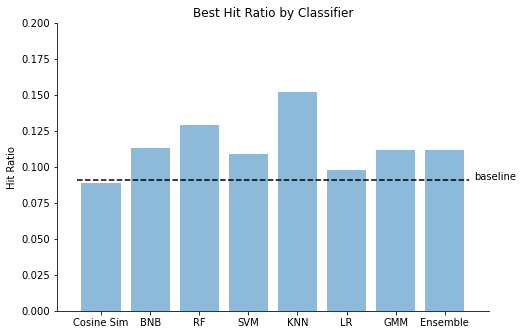

In [63]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar(clf_list[1:], clf_hit_rate_scores[1:], alpha=0.5)
ax.hlines(clf_hit_rate_scores[0], xmin=-0.5, xmax=7.5, color='black', linestyles='dashed', label='baseline')
ax.text(7.6, clf_hit_rate_scores[0], 'baseline')
ax.set_ylabel('Hit Ratio')
ax.set_ylim(0.0, 0.2)
ax.set_title('Best Hit Ratio by Classifier')
plt.show()

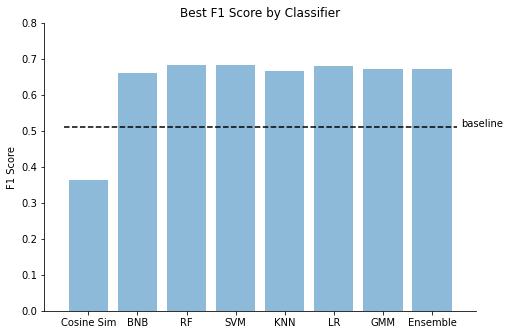

In [65]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar(clf_list[1:], clf_f1_scores[1:], alpha=0.5)
ax.hlines(clf_f1_scores[0], xmin=-0.5, xmax=7.5, color='black', linestyles='dashed', label='baseline')
ax.text(7.6, clf_f1_scores[0], 'baseline')
ax.set_ylabel('F1 Score')
ax.set_ylim(0.0, 0.8)
ax.set_title('Best F1 Score by Classifier')
plt.show()

### Step 9: Rerun the best models for several of the higher performing classifiers, but do so using the reduced parameters obtained by PCA dimensionality reduction

In this section, we'll use the same user list randomly generated above to test the classifiers, using the PCA reduced set of features in place of movies_df. To test the classifiers, we assigned the classifier the parameter with the best hit rate as found on the unreduced data (in theory, the classifiers should perform better on reduced data, due to decreased overfitting). The findings appear to confirm our previous theory that PCA dimensionality reduction is not a good fit - hit rate scores are lower than on unreduced data, even for the highest performing classifers.

#### Random Forest

In [72]:
# initialize classifier
rfc = RandomForestClassifier(n_estimators=best_rf_param, criterion='entropy')

# compute the hit rate
pca_hit_rate, pca_f1_score, pca_novelty_score = get_hit_rate(user_list, clf=rfc, num_rep=pca_features)
    
# print results
print('For n_estimators=={} on pca-reduced features hit rate=={:.3f} and f1 score=={:.3f}'.format(best_rf_param, pca_hit_rate, pca_f1_score))

For n_estimators==100 hit rate on pca-reduced features==0.117 and f1 score==0.675


#### SVM

In [73]:
# initialize classifier
svm = SVC(C=best_svm_param, kernel='rbf', probability=True)

# compute the hit rate
pca_hit_rate, pca_f1_score, pca_novelty_score = get_hit_rate(user_list, clf=rfc, num_rep=pca_features)
    
# print results
print('For C=={} on pca-reduced features hit rate=={:.3f} and f1 score=={:.3f}'.format(best_svm_param, pca_hit_rate, pca_f1_score))

For C==  1 hit rate on pca-reduced features==0.092 and f1 score==0.669


#### Logistic Regression

In [74]:
# initialize classifier
lr = LogisticRegression(C=best_lr_param)

# compute the hit rate
pca_hit_rate, pca_f1_score, pca_novelty_score = get_hit_rate(user_list, clf=lr, num_rep=pca_features)
    
# print results
print('For C=={} on pca-reduced features hit rate=={:.3f} and f1 score=={:.3f}'.format(best_lr_param, pca_hit_rate, pca_f1_score))

For C==0.1 hit rate on pca-reduced features==0.093 and f1 score==0.652


### Step 10: Rerun the best models for several of the higher performing classifiers, but do so using the reduced fetures obtained from feature importance values from a hyperparameter-tuned XGBoost Classifier.

#### Test various classifiers on the dataset of reduced movie features obtained by feature importance values from a hyperparameter-tuned XGBoost Classifier.

Similarly to our findings when testing the classifiers on PCA-reduced features, we also found worse performance when evaluating our models on a dataset with reduced features (those with non-zero importance to the weighted average, selected by XGBoost).

#### Random Forest

In [ ]:
# initialize classifier
rfc = RandomForestClassifier(n_estimators=best_rf_param, criterion='entropy')

# compute the hit rate
select_features_hit_rate, select_features_f1_score, select_features_novelty_score = get_hit_rate(user_list, clf=rfc, num_rep=xgb_features_csr)
    
# print results
print('For n_estimators=={:3} on selected features hit rate=={:.3f} and f1 score=={:.3f}'.format(best_rf_param, select_features_hit_rate, 
                                                                                                 select_features_f1_score))

#### SVM

In [ ]:
# initialize classifier
svm = SVC(C=best_svm_param, kernel='rbf', probability=True)

# compute the hit rate
select_features_hit_rate, select_features_f1_score, select_features_novelty_score = get_hit_rate(user_list, clf=rfc, num_rep=xgb_features_csr)
    
# print results
print('For C=={:3} on selected features hit rate=={:.3f} and f1 score=={:.3f}'.format(best_svm_param, select_features_hit_rate, 
                                                                                      select_features_f1_score))

#### Logistic Regression

In [ ]:
# initialize classifier
lr = LogisticRegression(C=best_lr_param)

# compute the hit rate
select_features_hit_rate, select_features_f1_score, select_features_novelty_score = get_hit_rate(user_list, clf=lr, num_rep=xgb_features_csr)
    
# print results
print('For C=={:3} on selected features hit rate=={:.3f} and f1 score=={:.3f}'.format(best_lr_param, select_features_hit_rate, 
                                                                                      select_features_f1_score))

### Step 11: Evaluate trade-off between hit rate and novelty score

For this section, we will use only the best classifiers (xxx, yyy, zzz) trained on xxx data.